In [203]:
#importing libraries

import random as rd
import hashlib
import phe
import rsa
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer


In [204]:
#declaring of varibles
numberOfExperts = 0
numberOfCandidates = 0
keySize = 0
#collection of homomophic public and private keys
dictionaryOfExpertPublicKeys = {}
dictionaryOfExpertPrivateKeys = {}

dictionaryOfCandidatesPublicKeys = {}
dictionaryOfCandidatesPrivateKeys = {}

#Variables for third framework@
dictionaryOfRandomNumberPerExpert = {}
dictionaryOftheSumOfRandomNumbermappedToEveryCandidate = {}
dictionaryOfRandomNumberGatheredFromOtherExperts = {}
dictionaryOfRandomNumberMappedToEveryCandidate = {}

#Collection of rsa public and private keys for digital signature
dictOfrsaPubKey = {}
dictOfrsaPriKey = {}
marksToCandidates3 = []
marksToCandidates4 = []


In [205]:
def initVariables(E, C, key):
    global numberOfExperts, numberOfCandidates,keySize
    numberOfExperts, numberOfCandidates,keySize = E, C, key

In [206]:
#this part of the code create the public and private homomorphic key pairs
def generateHomomorphickeyPairs():
    global publicKeyEmployer,privateKeyEmployer
    publicKeyEmployer,privateKeyEmployer = phe.generate_paillier_keypair(n_length=keySize)
    for i in range(numberOfExperts):
        x,y = phe.generate_paillier_keypair(n_length=keySize)
        dictionaryOfExpertPublicKeys[i] = x
        dictionaryOfExpertPrivateKeys[i] = y
        
    for i in range(numberOfCandidates):
        x,y = phe.generate_paillier_keypair(n_length=keySize)
        dictionaryOfCandidatesPublicKeys[i]= x
        dictionaryOfCandidatesPrivateKeys[i] = y 


In [207]:
#code to generate rsa public and private keys
def generateRSAKeys():
    global dictOfrsaPubKey, dicOfrsaPriKey
    for i in range(numberOfExperts):
        (pubkey, privkey) = rsa.newkeys(512)
        dictOfrsaPubKey[i],dictOfrsaPriKey[i] = pubkey, privkey 

In [208]:
# function to create digital signature
def createDigitalSignature(message,i):
    privkey = dictOfrsaPriKey[i]
    temp = str(message).encode()
    signature = rsa.sign(temp, privkey, 'SHA-1')
    return signature

In [209]:
def generateRandomNumberForEveryExpert():
    # global dictionaryOfRandomNumberPerExpert
    generatedRandomNumbers = [rd.randint(0,100) for x in range(numberOfExperts)]
    # print(generatedRandomNumbers)
    return generatedRandomNumbers
    # print(dictionaryOfSumGeneratedPerRandomNumber)

In [210]:
def forwardTheRespectiveRandomNumbers(idR,generatedRandomNumbers):
    encryptedRandomNumber = dictionaryOfExpertPublicKeys[idR].raw_encrypt(generatedRandomNumbers[idR])
    message = encryptedRandomNumber
    return message
# ,createDigitalSignature(encryptedRandomNumber,idS)

In [211]:
def performSMPCBetweenExperts():
    #this part of the code simulates the part where expert follow the smpc process
    #the random number assgned by all the experts has been mapped for every candidate
    # here the outer loop shows for which candidate the random number are being genereated and jth looop shows expert j is generating the random number for expert k and and passing it to expert k
    
    for i in range(numberOfCandidates):
        matrixOfForwardedMessages = [[0 for i in range(numberOfExperts)] for j in range(numberOfExperts)]
        sumList = []
        for j in range(numberOfExperts):
            generatedRandomNumbers = generateRandomNumberForEveryExpert()
            sumOfTheRandomNumbers = sum(generatedRandomNumbers) 
            sumList.append(sumOfTheRandomNumbers)

            for k in range(numberOfExperts):
                if(j != k):
                    message = forwardTheRespectiveRandomNumbers(k,generatedRandomNumbers)
                    matrixOfForwardedMessages[j][k] = message
                else:
                    # matrixOfForwardedMessages consist all random number such that from expert j to expert k
                    matrixOfForwardedMessages[j][k] = generatedRandomNumbers[j]
        dictionaryOfRandomNumberMappedToEveryCandidate[i] = matrixOfForwardedMessages
        dictionaryOftheSumOfRandomNumbermappedToEveryCandidate[i] = sumList
    # print(dictionaryOfRandomNumberMappedToEveryCandidate)
    # print(dictionaryOftheSumOfRandomNumbermappedToEveryCandidate)
    # print(dictionaryOfSumGeneratedPerRandomNumber)
    

    

In [212]:
# here in this code the outer lopp shows for whom the marks are being given , innner j loop shows expert j is giving the marks and kth loop shows other experts whp sent random number to j in smpc fuicntion
def generateHiddenScoreFrameWork3():
    global marksToCandidates3
    marksToCandidates3 = [[0 for i in range(numberOfCandidates)] for j in range(numberOfExperts)]
    for i in range(numberOfCandidates):
        for j in range(numberOfExperts):
            mark = rd.randint(0,10)
            hiddenScore = mark + dictionaryOftheSumOfRandomNumbermappedToEveryCandidate[i][j]
            sum  = 0
            for k in range(numberOfExperts):
                if(j != k):
                    encryptedRandomNumber = dictionaryOfRandomNumberMappedToEveryCandidate[i][k][j]
                    # print(encryptedRandomNumber)
                    sum  = sum + dictionaryOfExpertPrivateKeys[j].raw_decrypt(encryptedRandomNumber)
                else: 
                    sum = sum + dictionaryOfRandomNumberMappedToEveryCandidate[i][j][j]
            hiddenScore  = hiddenScore -sum
            # print(hiddenScore)
            # marksToCandidates contains matrix where j is the expert and i is candidate and what j gave to i isthe entry
            marksToCandidates3[j][i] = [hiddenScore, createDigitalSignature(hiddenScore,j)]
            


In [213]:
def candidateManagerFrameWork3BestCandidate():
    array = []
    for i in range(numberOfCandidates):
        sum = 0
        for j in range(numberOfExperts):
            cummulativeScore = marksToCandidates3[j][i][0]
            sum  = sum + cummulativeScore
        array.append(sum)
    # print(array)
    # print(array.index(max(array)))

In [214]:
def expertFunctionToGiveMarks3():
    start = timer()
    generateHiddenScoreFrameWork3()
    end = timer()
    return end - start


frameworks of 4

In [215]:
def generateHiddenScoreFrameWork4():
    global marksToCandidates4
    marksToCandidates4 = [[0 for i in range(numberOfCandidates)] for j in range(numberOfExperts)]
    for i in range(numberOfCandidates):
        for j in range(numberOfExperts):
            mark = rd.randint(0,10)
            hiddenScore = mark + dictionaryOftheSumOfRandomNumbermappedToEveryCandidate[i][j]
            sum  = 0
            for k in range(numberOfExperts):
                if(j != k):
                    encryptedRandomNumber = dictionaryOfRandomNumberMappedToEveryCandidate[i][k][j]
                    # print(encryptedRandomNumber)
                    sum  = sum + dictionaryOfExpertPrivateKeys[j].raw_decrypt(encryptedRandomNumber)
                else: 
                    sum = sum + dictionaryOfRandomNumberMappedToEveryCandidate[i][j][j]
            hiddenScore  = hiddenScore -sum
            # print(hiddenScore)
            marksToCandidates4[j][i] = [publicKeyEmployer.raw_encrypt(hiddenScore),createDigitalSignature(publicKeyEmployer.raw_encrypt(hiddenScore),j)]

In [216]:
def candidateManagerFrameWork4BestCandidate():
    array = []
    for i in range(numberOfCandidates):
        sum = 1
        for j in range(numberOfExperts):
            cummulativeScore = marksToCandidates4[j][i][0]
            sum  = sum * cummulativeScore
        array.append(sum)
    return array


In [217]:
def employerFindsTheBestCandidate(array):
    marksOfCandidates = [privateKeyEmployer.raw_decrypt(x) for x in array]
    # print(marksOfCandidates)
    # print(marksOfCandidates.index(max(marksOfCandidates)))

In [218]:
def expertFunctionToGiveMarks4():
    start = timer()
    generateHiddenScoreFrameWork4()
    end = timer()
    return end - start

In [219]:
def runSimulation(experts,candidates,flag,keySize):
    experts = experts
    timeList3 = []
    timeList4 = []
    candidates = candidates
    if flag == "candidates":
        for i in range(len(candidates)):
            start = timer()
            initVariables(experts,candidates[i],keySize)
            generateHomomorphickeyPairs()
            generateRSAKeys()
            performSMPCBetweenExperts()
            end = timer()
            t1 = end - start
            for z in range(0,2):
                if z == 0:
                    t2 = expertFunctionToGiveMarks3()
                    start = timer()
                    candidateManagerFrameWork3BestCandidate() 
                    end = timer()
                    t3 = end - start
                    timeList3.append(t1 + (t2/experts) + t3)
                else:
                    t2 = expertFunctionToGiveMarks4()
                    start = timer()
                    array = candidateManagerFrameWork4BestCandidate()
                    employerFindsTheBestCandidate(array) 
                    end = timer()
                    t3 = end - start
                    timeList4.append(t1 + (t2/experts) + t3)               
    else: 
        for i in range(len(experts)):
            start = timer()
            initVariables(experts[i],candidates,keySize)
            generateHomomorphickeyPairs()
            generateRSAKeys()
            performSMPCBetweenExperts()
            end = timer()
            t1 =end - start
            for m in range(0,2):
                if m == 0:
                    t2 = expertFunctionToGiveMarks3()
                    start = timer()
                    candidateManagerFrameWork3BestCandidate()
                    end = timer()
                    t3 = end - start
                    timeList3.append( t1 + (t2/ experts[i]) + t3)
                else:
                    t2 = expertFunctionToGiveMarks4()
                    start = timer()
                    array = candidateManagerFrameWork4BestCandidate()
                    employerFindsTheBestCandidate(array)
                    end = timer()
                    t3 = end - start
                    timeList4.append( t1 + (t2/ experts[i]) + t3)               
    # print(timeList)
    return ([timeList3, timeList4])

In [220]:
#this part of the code run the simulation for defined number of times and helps us to calcuate average execution time
def averageTimeConsumedFunction(experts, candidates,flag,keySize):
    timeMatrix3 = []
    timeMatrix4 = []
    for i in range(0,4):
        timeLists= runSimulation(experts, candidates,flag,keySize)
        timeMatrix3.append(timeLists[0])
        timeMatrix4.append(timeLists[1])
    # print(timeMatrix)        
    arr3 = np.array(timeMatrix3, dtype='float32')
    arr4 = np.array(timeMatrix4, dtype='float32')
    # print(arr)
    columns_average3 = arr3.mean(axis=0)
    columns_average4 = arr4.mean(axis=0)

    if flag == "candidates":
        plt.title("Number of experts " + str(experts) + " and key size of " + str(keySize))
        plt.xlabel("Number Of Candidates")
        plt.ylabel("Average Execution Time(seconds)")   
        plt.bar(candidates, columns_average3)
        plt.show()
        print(columns_average3)
        plt.bar(candidates, columns_average4)
        plt.show()
        print(columns_average4)
        
    else :
        plt.title("Number of candidates = " + str(candidates) + " and key size of " + str(keySize))
        plt.xlabel("Number Of Experts")
        plt.ylabel("Average Execution Time(seconds)")   
        plt.bar(experts, columns_average3)
        plt.show()
        print(columns_average3)
        plt.bar(experts, columns_average3)
        plt.show()
        print(columns_average4)

    
    return columns_average3, columns_average4

        


In [221]:
def simulationHavingExpertsvariableCandidatesConst(experts,candidates,flag,keySize):
    column_average3, column_average4 = averageTimeConsumedFunction(experts,candidates,flag,keySize)
    return column_average3,column_average4

In [222]:
def simulationHavingExpertsConstCandidatesVariable(experts, candidates,flag,keySize):
    column_average3, column_average4 = averageTimeConsumedFunction(experts,candidates,flag,keySize)
    return column_average3, column_average4
    

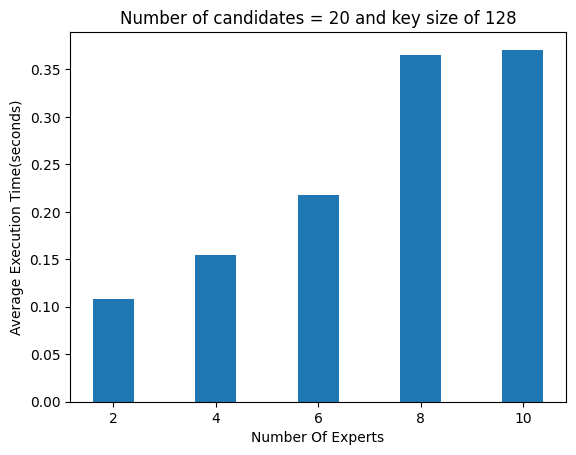

[0.10786579 0.15496714 0.21801744 0.36508906 0.37068895]


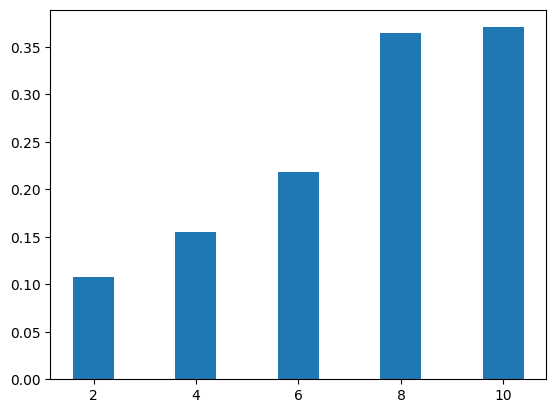

[0.11012239 0.15772764 0.22014381 0.3673306  0.37296152]


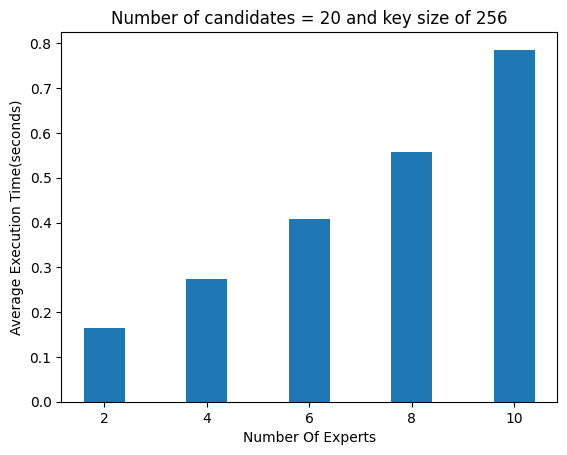

[0.16476284 0.27497405 0.40853074 0.5573238  0.7857262 ]


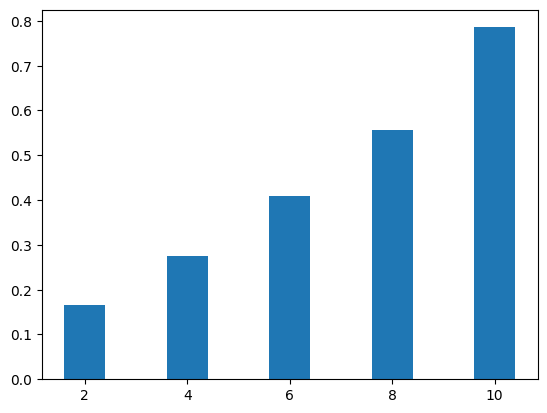

[0.17570166 0.28582662 0.41914797 0.56803685 0.79581213]


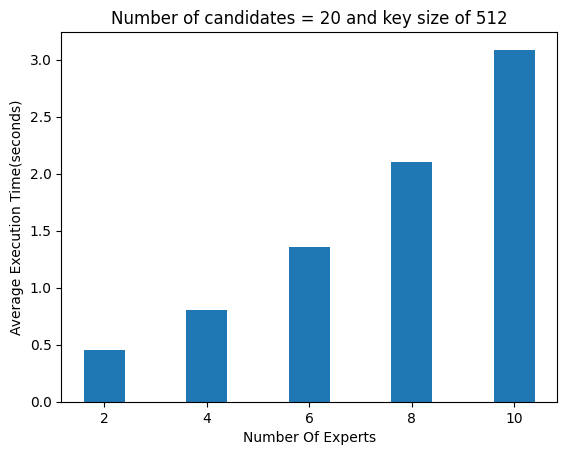

[0.45243847 0.8035923  1.3596793  2.100716   3.0877466 ]


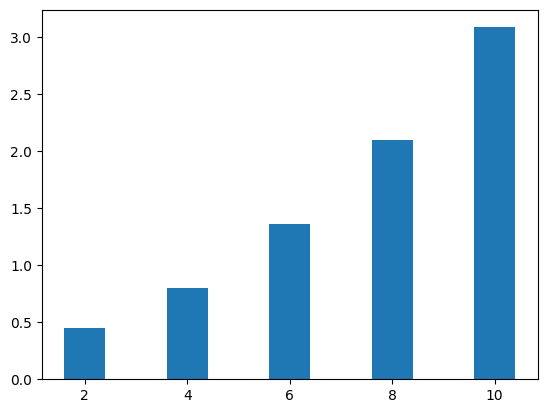

[0.5124863  0.86313677 1.4215791  2.161273   3.1482637 ]
Stored 'F3Time' (list)
Stored 'F4Time' (list)


In [223]:
keys = [128,256,512]
F3Time = []
F4Time = []
for i in range(0,3):
   time =  simulationHavingExpertsvariableCandidatesConst([2,4,6,8,10], 20, "experts", keys[i])
   F3Time.append(time[0])
   F4Time.append(time[1])
%store F3Time
%store F4Time


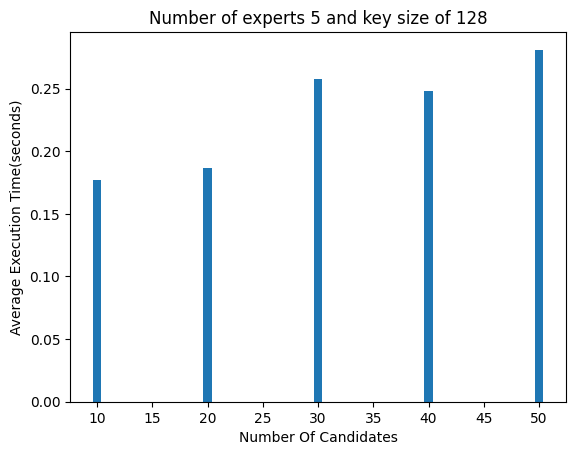

[0.1768324  0.18633197 0.25795776 0.24844047 0.28107452]


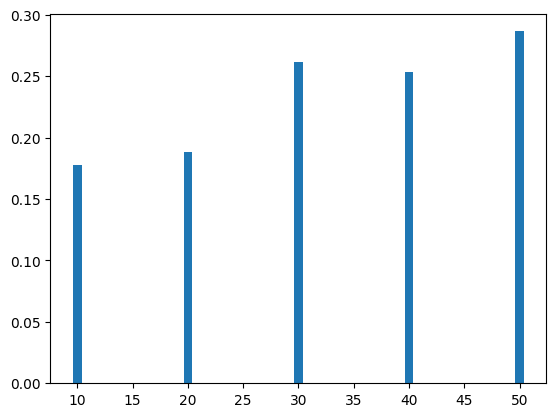

[0.17789273 0.18863003 0.26129073 0.253111   0.28656936]


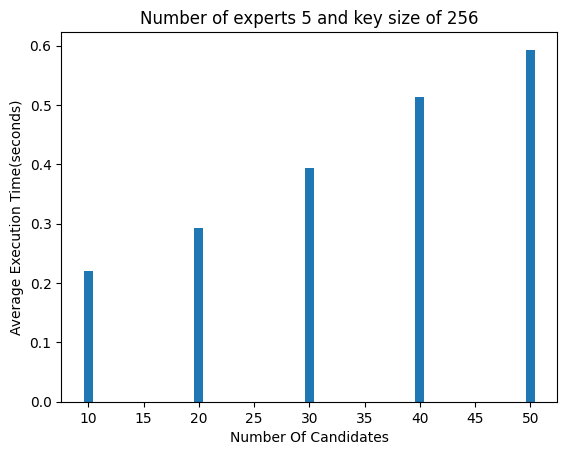

[0.22102311 0.29320884 0.39320236 0.51331466 0.593293  ]


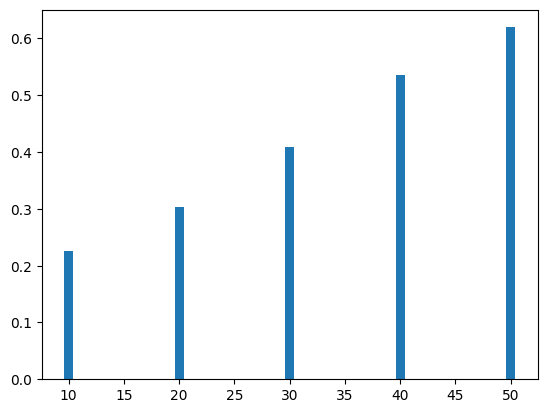

[0.2262831  0.30407062 0.40979016 0.5351908  0.6197463 ]


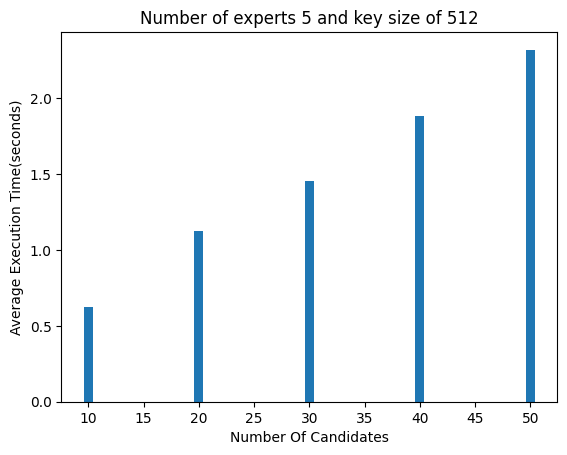

[0.62569517 1.1223674  1.4563981  1.8824224  2.3182359 ]


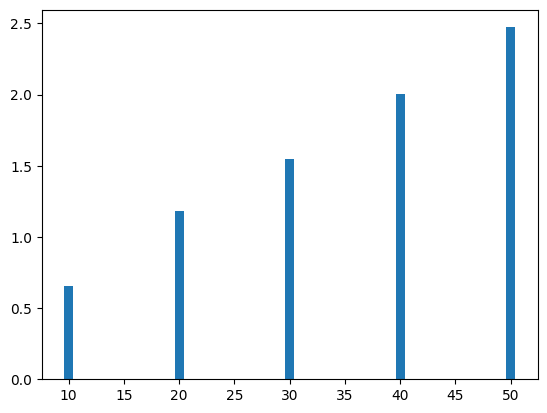

[0.6568267 1.1821617 1.5481439 2.004622  2.4732618]
Stored 'F3TimeCandidateVariable' (list)
Stored 'F4TimeCandidateVariable' (list)


In [227]:
keys = [128,256,512]
F3TimeCandidateVariable = []
F4TimeCandidateVariable = []
for i in range(0,3):
    time = simulationHavingExpertsConstCandidatesVariable(5,[10,20,30,40,50],"candidates",keys[i])
    F3TimeCandidateVariable.append(time[0])
    F4TimeCandidateVariable.append(time[1])
%store F3TimeCandidateVariable
%store F4TimeCandidateVariable

In [225]:
# z = 10
# timelist = []
# expertlist = [z + (i * 10) for i  in range(0,20)]
# print(expertlist)
# timelist = runSimulation(expertlist,20,"experts",256)
# plt.plot(expertlist,timelist)


In [226]:
F4TimeCandidateVariable

[]